In [ ]:
from src.hierarchical_model import nc_hierarchical_model_general, hierarchical_logistic_model, \
    heteroskedastic_hierarchical_model, heteroskedastic_logistic_hierarchical_model
from src.invariance_tests import invariance_tests, invariance_tests_with_dynamic_rope, bootstrap_data, plot_predictor_heatmaps
from src.confounding_analysis import test_backdoor_confounding, plot_confounding_results
from jax import random
from numpyro.infer import MCMC, NUTS
import numpy as np
import jax.numpy as jnp
import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(42)

In [71]:
# Load the dataset directly from the Rdatasets repository
url = "https://vincentarelbundock.github.io/Rdatasets/csv/AER/CollegeDistance.csv"
df = pd.read_csv(url)

# Display the first few rows
print(df.head())

   rownames  gender ethnicity      score fcollege mcollege home urban  unemp  \
0         1    male     other  39.150002      yes       no  yes   yes    6.2   
1         2  female     other  48.869999       no       no  yes   yes    6.2   
2         3    male     other  48.740002       no       no  yes   yes    6.2   
3         4    male      afam  40.400002       no       no  yes   yes    6.2   
4         5  female     other  40.480000       no       no   no   yes    5.6   

   wage  distance  tuition  education income region  
0  8.09       0.2  0.88915         12   high  other  
1  8.09       0.2  0.88915         12    low  other  
2  8.09       0.2  0.88915         12    low  other  
3  8.09       0.2  0.88915         12    low  other  
4  8.09       0.4  0.88915         13    low  other  


In [72]:
# Drop the unnecessary index column
df = df.drop(columns=["rownames"])

# Summary of the dataset
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4739 entries, 0 to 4738
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   gender     4739 non-null   object 
 1   ethnicity  4739 non-null   object 
 2   score      4739 non-null   float64
 3   fcollege   4739 non-null   object 
 4   mcollege   4739 non-null   object 
 5   home       4739 non-null   object 
 6   urban      4739 non-null   object 
 7   unemp      4739 non-null   float64
 8   wage       4739 non-null   float64
 9   distance   4739 non-null   float64
 10  tuition    4739 non-null   float64
 11  education  4739 non-null   int64  
 12  income     4739 non-null   object 
 13  region     4739 non-null   object 
dtypes: float64(5), int64(1), object(8)
memory usage: 518.5+ KB


score        unemp         wage     distance      tuition  \
count  4739.000000  4739.000000  4739.000000  4739.000000  4739.000000   
mean     50.889029     7.597215     9.500506     1.802870     0.814608   
std       8.701910     2.763581     1.343067     2.297128     0.339504   
min      28.950001     1.400000     6.590000     0.000000     0.257510   
25%      43.924999     5.900000     8.850000     0.400000     0.484990   
50%      51.189999     7.100000     9.680000     1.000000     0.824480   
75%      57.769999     8.900000    10.150000     2.500000     1.127020   
max      72.809998    24.900000    12.960000    20.000000     1.404160   

         education  
count  4739.000000  
mean     13.807765  
std       1.789107  
min      12.000000  
25%      12.000000  
50%      13.000000  
75%      16.000000  
max      18.000000

In [73]:
# Ensure the target variable `education` is binary
df['education'] = (df['education'] > 16).astype(int)

df["environment"] = np.where(df["distance"] <= (df['distance'].median()).astype(int), 0, 1)
e = df['environment'].values
E = len(df['environment'].unique())

scaler = StandardScaler()
continuous_cols = ['score', 'tuition', 'unemp', 'wage']
df[continuous_cols] = scaler.fit_transform(df[continuous_cols])

# Convert categorical variables to dummies
df = pd.get_dummies(
    df,
    columns=['gender', 'ethnicity', 'fcollege', 'mcollege', 'home', 'urban', 'income', 'region'],
    drop_first=True
)

In [74]:
n_environments = 2
m_splits = 100
#Split by zones

X_cols = [col for col in df.columns if col not in ['education', 'distance']]
X = df[X_cols].values
Y = df['education'].values

# Convert to JAX arrays
X_jax = jnp.array(X, dtype=jnp.float32)
Y_jax = jnp.array(Y, dtype=jnp.int32)  # Must be integers for Bernoulli
e_jax = jnp.array(e, dtype=jnp.int32)

In [62]:
posterior_samples_grouped = []
split_results = []

for split_index in range(m_splits):
    random_env_assignments = np.random.choice(n_environments, size=len(Y), replace=True)
    e_jax = jnp.array(random_env_assignments, dtype=jnp.int32)

    nuts_kernel = NUTS(nc_hierarchical_model_general)
    mcmc = MCMC(nuts_kernel, num_warmup=1000, num_samples=2000, num_chains=1)
    mcmc.run(random.PRNGKey(42), N=X_jax.shape[0], D=X_jax.shape[1],
             E=n_environments, e=e_jax, X=X_jax, y=Y_jax, model_func=hierarchical_logistic_model)
    posterior_samples = mcmc.get_samples()
    posterior_samples_grouped.append(posterior_samples)

    invariance_results = invariance_tests_with_dynamic_rope(
        posterior_samples,
        D=X_jax.shape[1],
        E=n_environments,
        rope_type="tenth_sd",
        printing=False,
        X_cols=X_cols
    )
    split_results.append(invariance_results)



  0%|          | 0/3000 [00:00<?, ?it/s]2024-12-31 17:09:25.346213: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 16m6.497267s

********************************
[Compiling module jit__body_fn] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
sample: 100%|██████████| 3000/3000 [16:18<00:00,  3.07it/s, 127 steps of size 3.57e-02. acc. prob=0.86]  


In [63]:
specific_splits = {
    "Gender": (df["gender_male"].values),  # 0 if female, 1 if male (assuming `gender_male` is 1 for male)
    "Ethnicity Hispanic": (df['ethnicity_hispanic'].values),
    "Distance": (df["distance"] > df['distance'].median().astype(int)).astype(int),
    "Home": (df["home_yes"].values),      # if `home_yes` is 1, else 0
    #"RegionWest": (df["region_west"].values), # 1 if West, 0 otherwise
}

specific_split_results = {}

for env_name, env_array in specific_splits.items():
    # Convert to int32 for JAX
    e_jax_specific = jnp.array(env_array, dtype=jnp.int32)

    # We assume each of these “specific splits” has exactly 2 environments, E=2
    nuts_kernel = NUTS(nc_hierarchical_model_general)
    mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000, num_chains=1)
    mcmc.run(
        random.PRNGKey(42),
        N=X_jax.shape[0],
        D=X_jax.shape[1],
        E=2,
        e=e_jax_specific,
        X=X_jax,
        y=Y_jax,
        model_func=hierarchical_logistic_model
    )
    posterior_samples_specific = mcmc.get_samples()

    invariance_results_specific = invariance_tests_with_dynamic_rope(
        posterior_samples_specific,
        D=X_jax.shape[1],
        E=2,
        rope_type="tenth_sd",
        printing=False,
        X_cols=X_cols
    )
    # Store the results in the dictionary
    specific_split_results[env_name] = invariance_results_specific



sample: 100%|██████████| 1500/1500 [15:58<00:00,  1.56it/s, 255 steps of size 1.76e-02. acc. prob=0.89]   


sample: 100%|██████████| 3000/3000 [01:06<00:00, 44.89it/s, 255 steps of size 2.37e-02. acc. prob=0.88] 


--------- Predictor 0 ---------
beta_score_env_0 HDI: [0.7768, 1.1395]
beta_score_env_0 ROPE: [-0.0092, 0.0092]


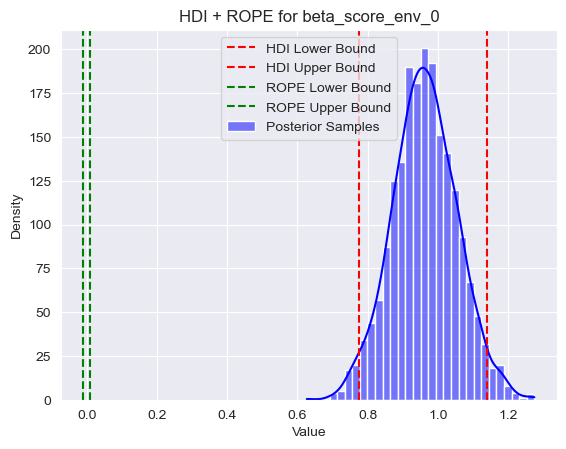

beta_score_env_1 HDI: [0.7595, 1.1920]
beta_score_env_1 ROPE: [-0.0109, 0.0109]


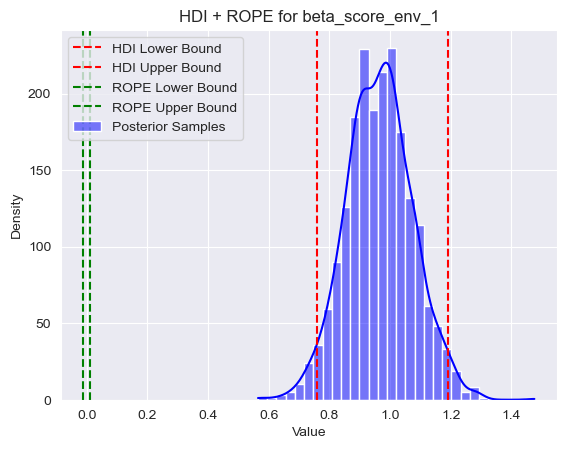

mu_score HDI: [0.0629, 1.4271]
mu_score ROPE: [-0.3207, 0.3207]


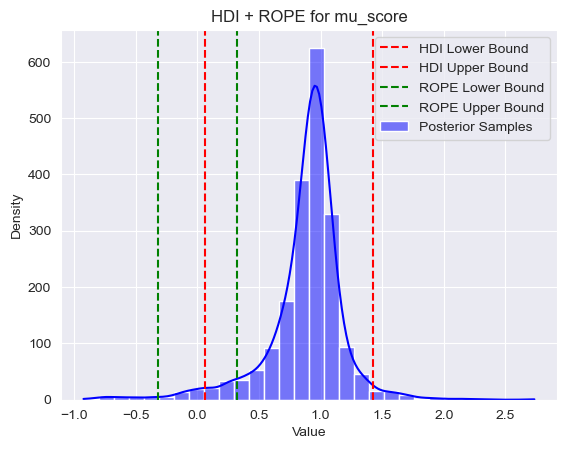

Local tests: ['Rejected', 'Rejected']
Global test for mu: Undecided
Pooling Factor (normal): 1.0000
--------- Predictor 1 ---------
beta_unemp_env_0 HDI: [0.0379, 0.4111]
beta_unemp_env_0 ROPE: [-0.0097, 0.0097]


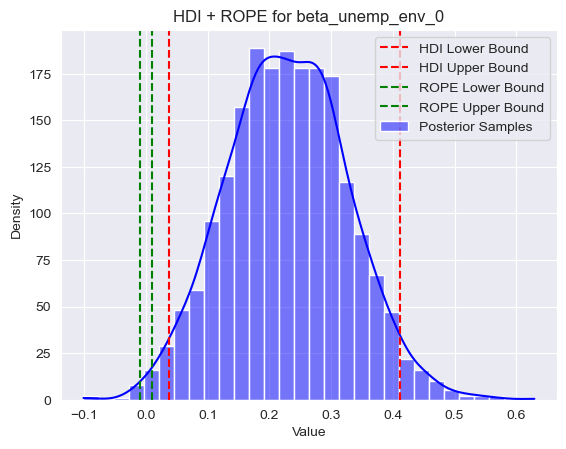

beta_unemp_env_1 HDI: [-0.0480, 0.2998]
beta_unemp_env_1 ROPE: [-0.0089, 0.0089]


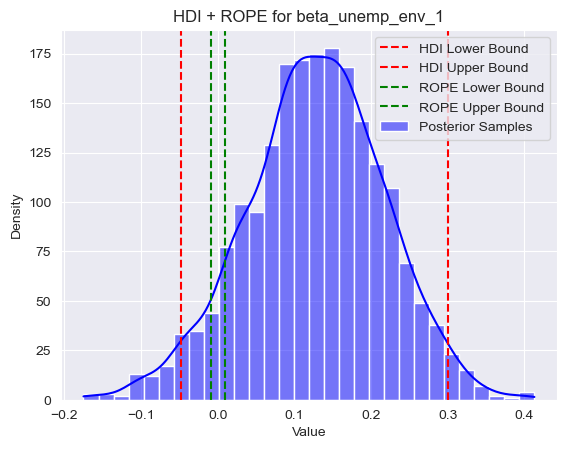

mu_unemp HDI: [-0.5264, 0.8787]
mu_unemp ROPE: [-0.3231, 0.3231]


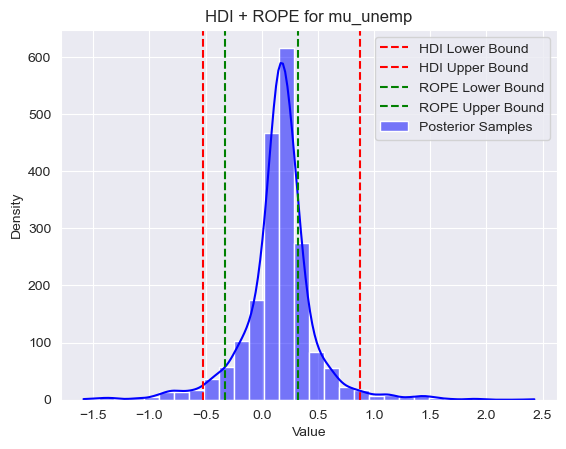

Local tests: ['Rejected', 'Undecided']
Global test for mu: Undecided
Pooling Factor (normal): 0.9756
--------- Predictor 2 ---------
beta_wage_env_0 HDI: [-0.1828, 0.1495]
beta_wage_env_0 ROPE: [-0.0085, 0.0085]


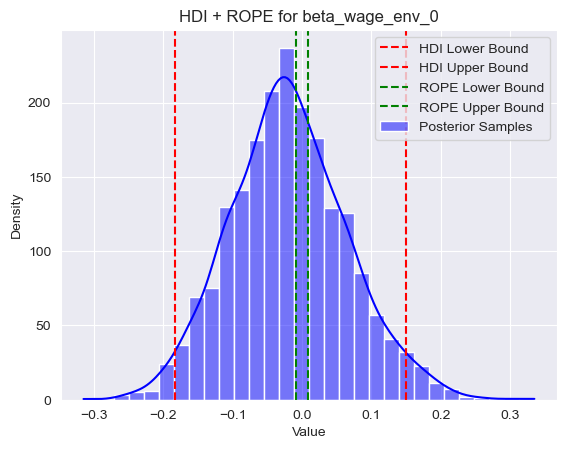

beta_wage_env_1 HDI: [-0.3262, 0.0688]
beta_wage_env_1 ROPE: [-0.0100, 0.0100]


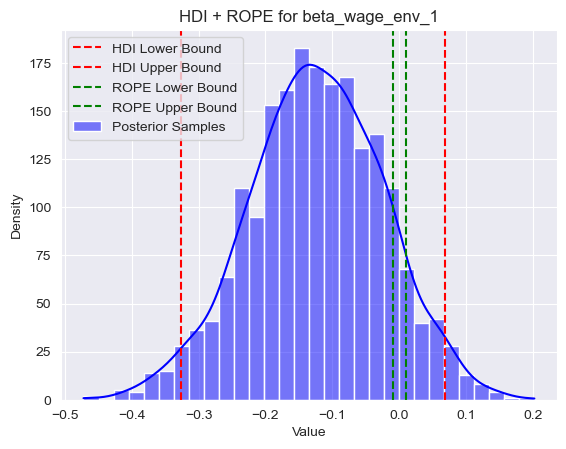

mu_wage HDI: [-0.6749, 0.7299]
mu_wage ROPE: [-0.3266, 0.3266]


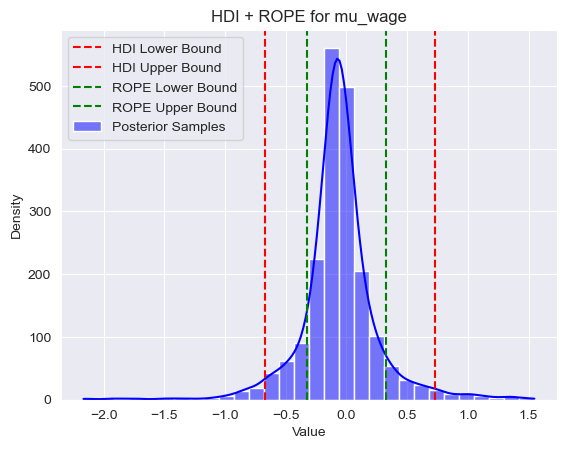

Local tests: ['Undecided', 'Undecided']
Global test for mu: Undecided
Pooling Factor (normal): 0.9748
--------- Predictor 3 ---------
beta_distance_env_0 HDI: [2.0312, 3.4221]
beta_distance_env_0 ROPE: [-0.0363, 0.0363]


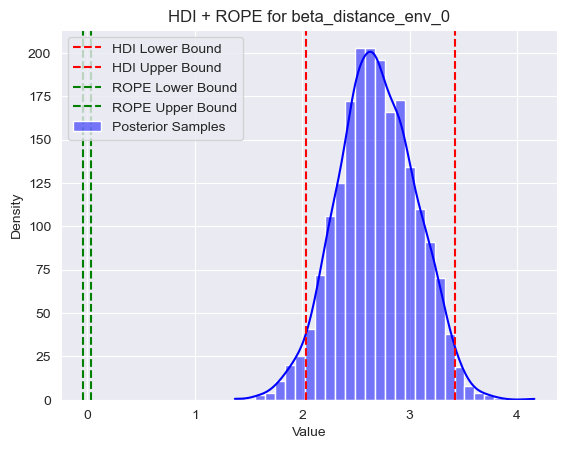

beta_distance_env_1 HDI: [-0.7184, -0.2014]
beta_distance_env_1 ROPE: [-0.0136, 0.0136]


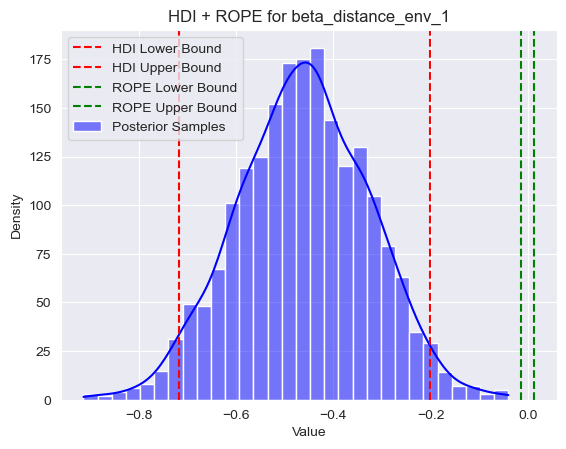

mu_distance HDI: [-1.1887, 2.0405]
mu_distance ROPE: [-0.8201, 0.8201]


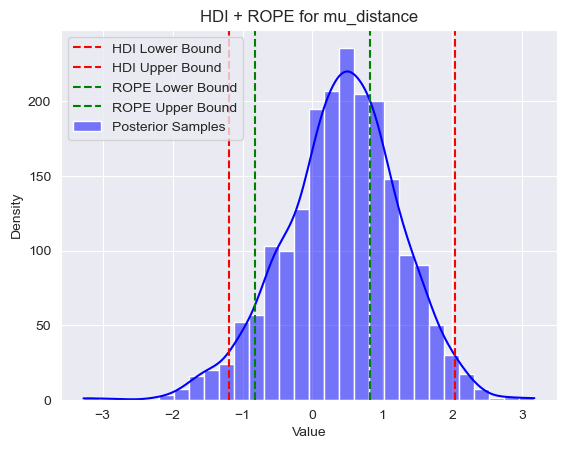

Local tests: ['Rejected', 'Rejected']
Global test for mu: Undecided
Pooling Factor (normal): 0.0000
--------- Predictor 4 ---------
beta_tuition_env_0 HDI: [-0.4583, -0.0514]
beta_tuition_env_0 ROPE: [-0.0104, 0.0104]


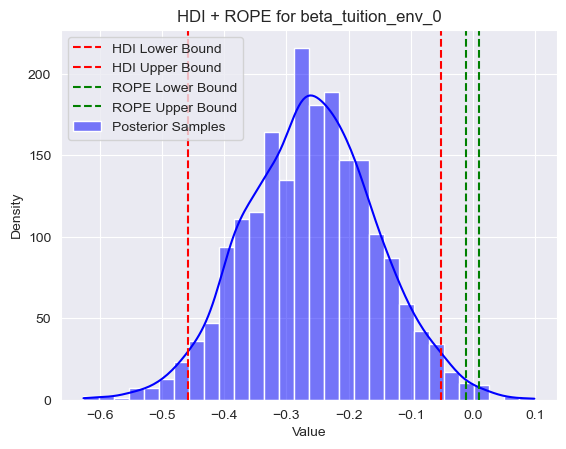

beta_tuition_env_1 HDI: [-0.4673, -0.0032]
beta_tuition_env_1 ROPE: [-0.0120, 0.0120]


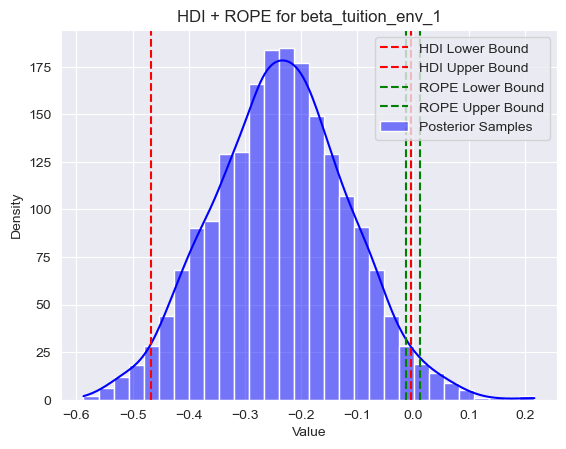

mu_tuition HDI: [-0.8628, 0.4133]
mu_tuition ROPE: [-0.3006, 0.3006]


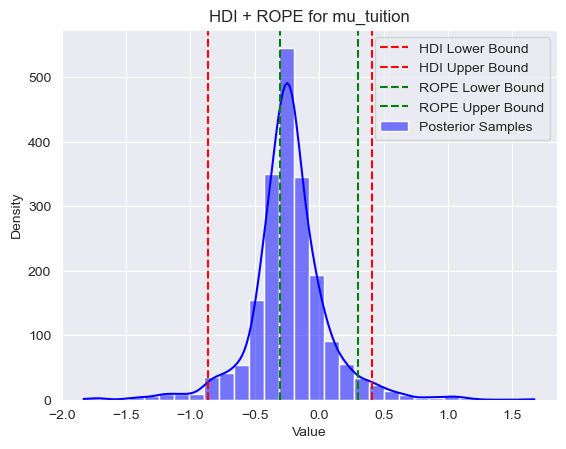

Local tests: ['Rejected', 'Undecided']
Global test for mu: Undecided
Pooling Factor (normal): 0.9982
--------- Predictor 5 ---------
beta_environment_env_0 HDI: [-5.4864, 6.0743]
beta_environment_env_0 ROPE: [-0.2817, 0.2817]


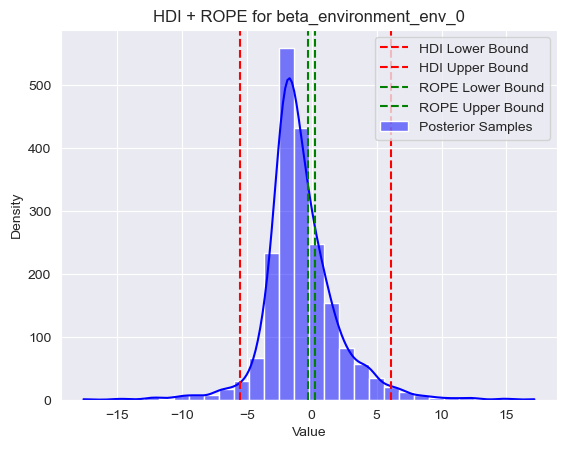

beta_environment_env_1 HDI: [-3.4190, -1.4997]
beta_environment_env_1 ROPE: [-0.0496, 0.0496]


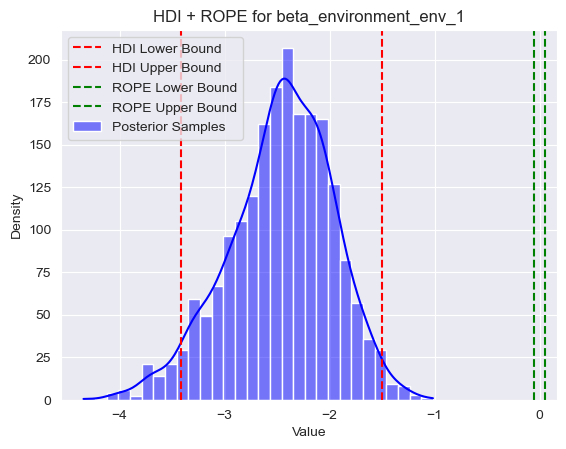

mu_environment HDI: [-2.6312, 1.1565]
mu_environment ROPE: [-1.0094, 1.0094]


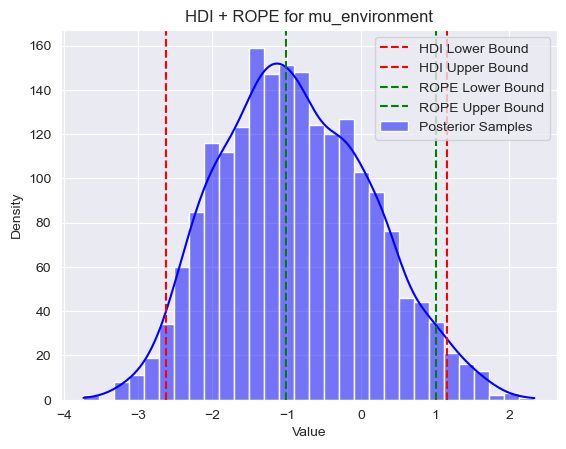

Local tests: ['Undecided', 'Rejected']
Global test for mu: Undecided
Pooling Factor (normal): 0.8384
--------- Predictor 6 ---------
beta_gender_male_env_0 HDI: [-0.5839, 0.0034]
beta_gender_male_env_0 ROPE: [-0.0153, 0.0153]


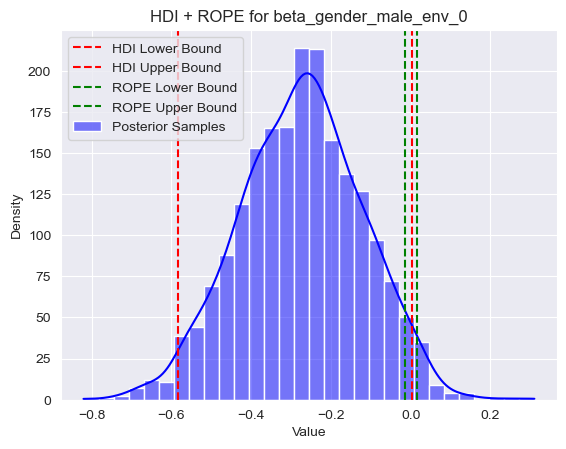

beta_gender_male_env_1 HDI: [-0.3436, 0.3860]
beta_gender_male_env_1 ROPE: [-0.0190, 0.0190]


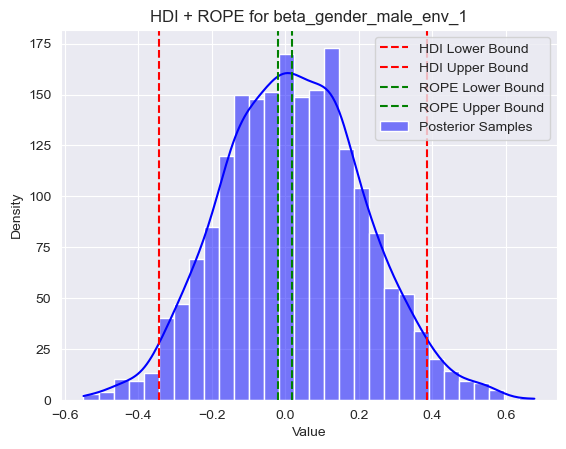

mu_gender_male HDI: [-1.0455, 0.7474]
mu_gender_male ROPE: [-0.4225, 0.4225]


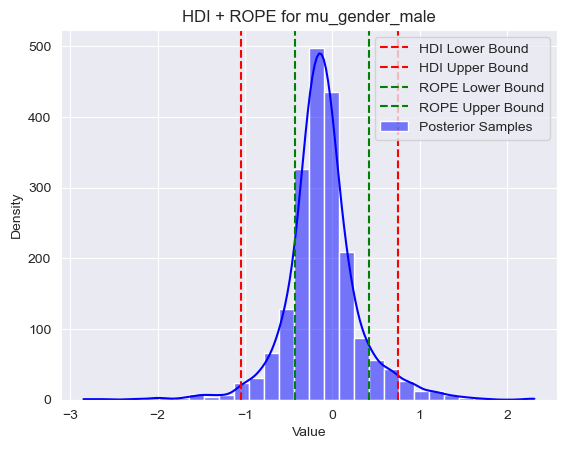

Local tests: ['Undecided', 'Undecided']
Global test for mu: Undecided
Pooling Factor (normal): 0.8825
--------- Predictor 7 ---------
beta_ethnicity_hispanic_env_0 HDI: [-0.9280, 0.0239]
beta_ethnicity_hispanic_env_0 ROPE: [-0.0246, 0.0246]


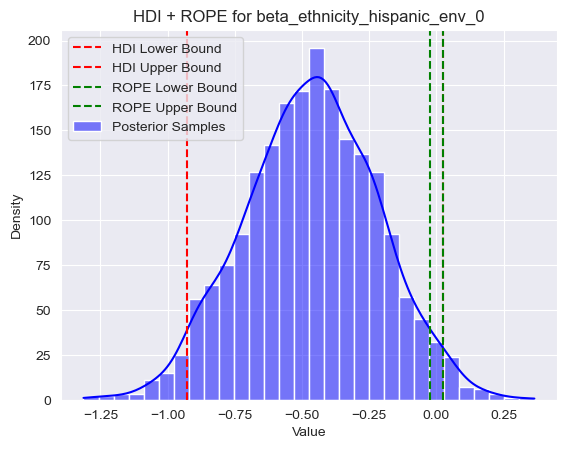

beta_ethnicity_hispanic_env_1 HDI: [-0.3956, 1.3724]
beta_ethnicity_hispanic_env_1 ROPE: [-0.0452, 0.0452]


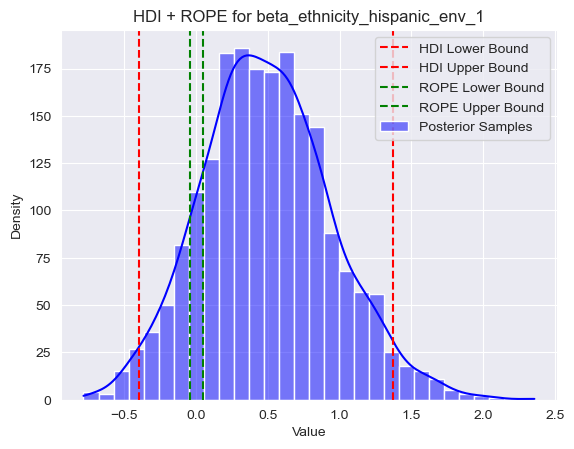

mu_ethnicity_hispanic HDI: [-1.1318, 1.2034]
mu_ethnicity_hispanic ROPE: [-0.5685, 0.5685]


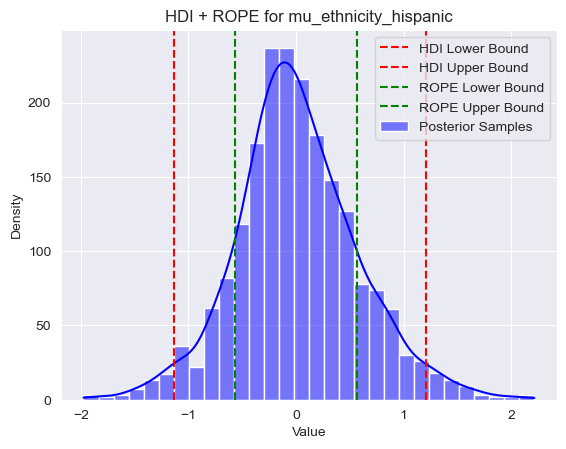

Local tests: ['Undecided', 'Undecided']
Global test for mu: Undecided
Pooling Factor (normal): 0.3832
--------- Predictor 8 ---------
beta_ethnicity_other_env_0 HDI: [-1.1995, -0.4606]
beta_ethnicity_other_env_0 ROPE: [-0.0192, 0.0192]


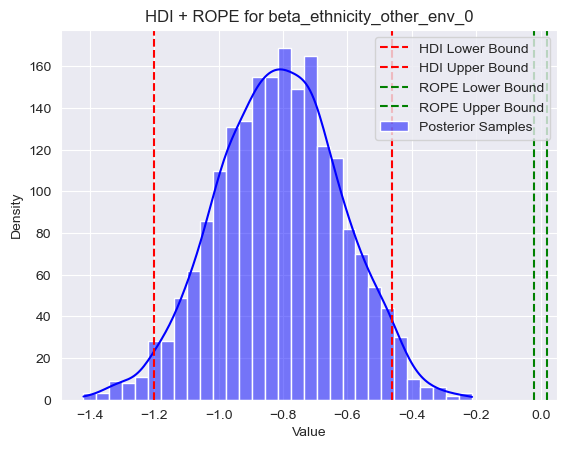

beta_ethnicity_other_env_1 HDI: [-1.1075, 0.3734]
beta_ethnicity_other_env_1 ROPE: [-0.0381, 0.0381]


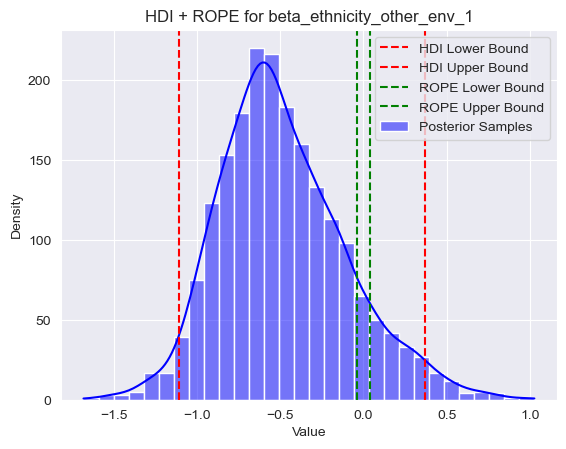

mu_ethnicity_other HDI: [-1.3566, 0.6120]
mu_ethnicity_other ROPE: [-0.4864, 0.4864]


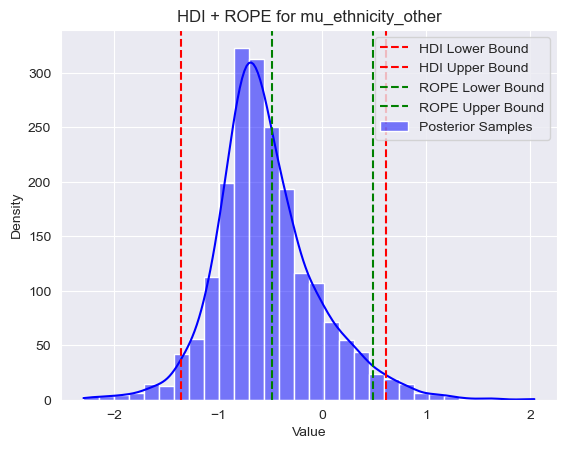

Local tests: ['Rejected', 'Undecided']
Global test for mu: Undecided
Pooling Factor (normal): 0.8851
--------- Predictor 9 ---------
beta_fcollege_yes_env_0 HDI: [0.0144, 0.6977]
beta_fcollege_yes_env_0 ROPE: [-0.0175, 0.0175]


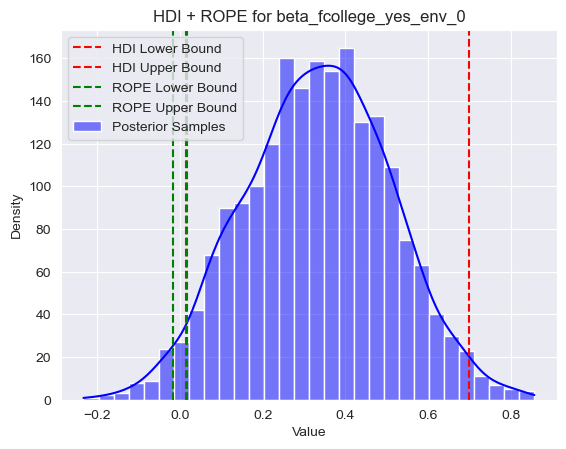

beta_fcollege_yes_env_1 HDI: [0.1512, 1.0495]
beta_fcollege_yes_env_1 ROPE: [-0.0231, 0.0231]


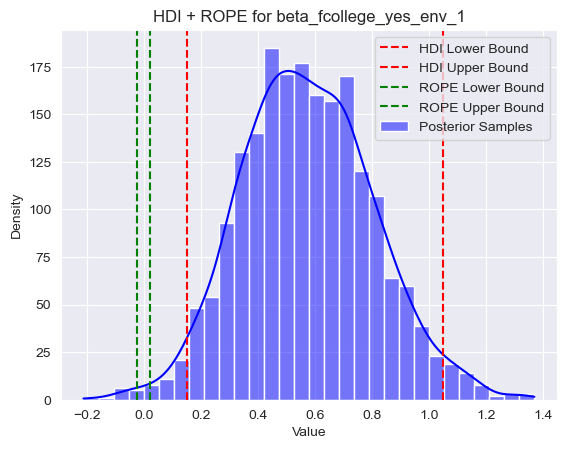

mu_fcollege_yes HDI: [-0.5550, 1.2048]
mu_fcollege_yes ROPE: [-0.4179, 0.4179]


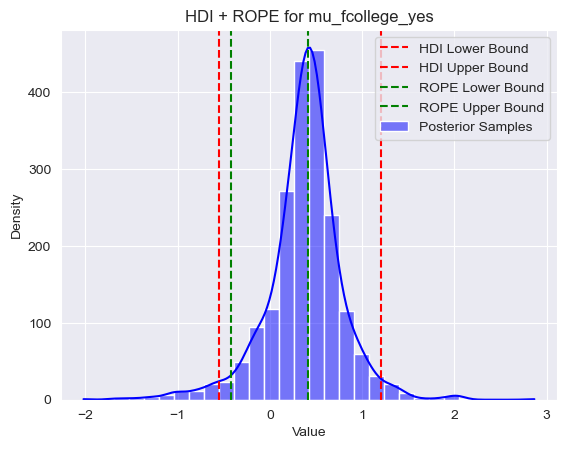

Local tests: ['Undecided', 'Rejected']
Global test for mu: Undecided
Pooling Factor (normal): 0.9199
--------- Predictor 10 ---------
beta_mcollege_yes_env_0 HDI: [-0.0825, 0.6169]
beta_mcollege_yes_env_0 ROPE: [-0.0183, 0.0183]


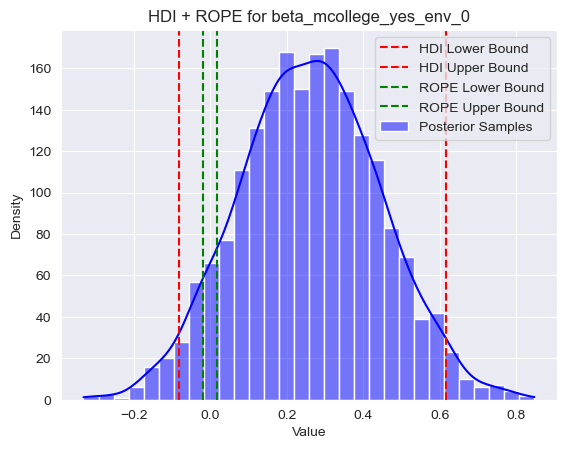

beta_mcollege_yes_env_1 HDI: [-0.5376, 0.4253]
beta_mcollege_yes_env_1 ROPE: [-0.0253, 0.0253]


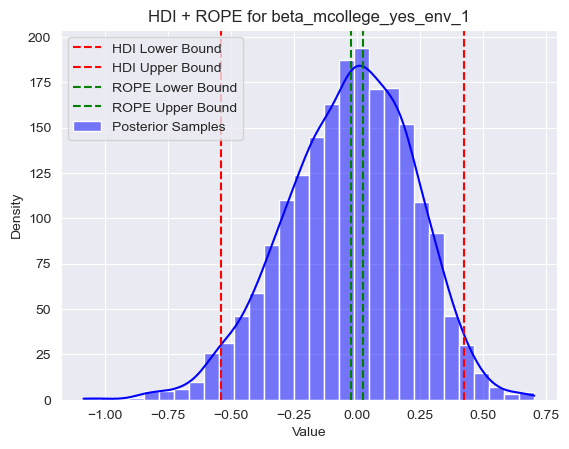

mu_mcollege_yes HDI: [-0.8975, 0.8858]
mu_mcollege_yes ROPE: [-0.4114, 0.4114]


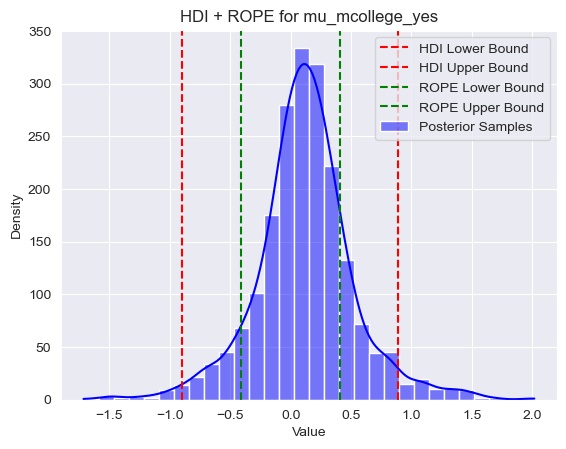

Local tests: ['Undecided', 'Undecided']
Global test for mu: Undecided
Pooling Factor (normal): 0.8794
--------- Predictor 11 ---------
beta_home_yes_env_0 HDI: [-0.6236, 0.0887]
beta_home_yes_env_0 ROPE: [-0.0185, 0.0185]


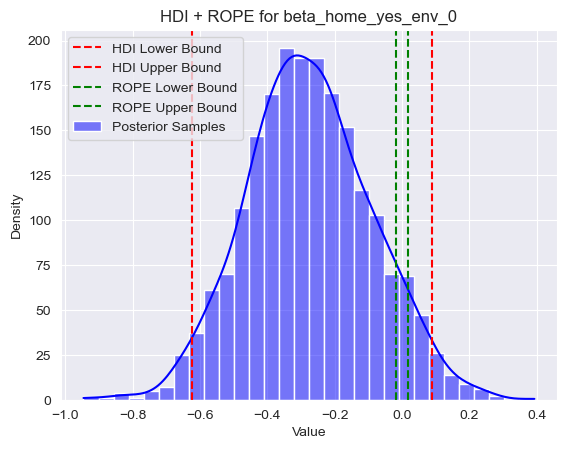

beta_home_yes_env_1 HDI: [-0.4212, 0.6847]
beta_home_yes_env_1 ROPE: [-0.0290, 0.0290]


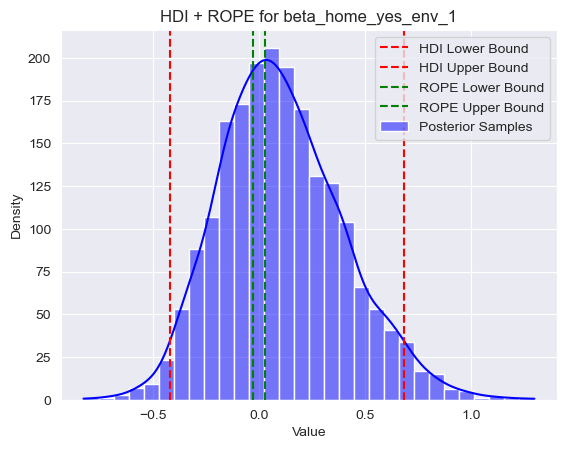

mu_home_yes HDI: [-0.9676, 0.9813]
mu_home_yes ROPE: [-0.4551, 0.4551]


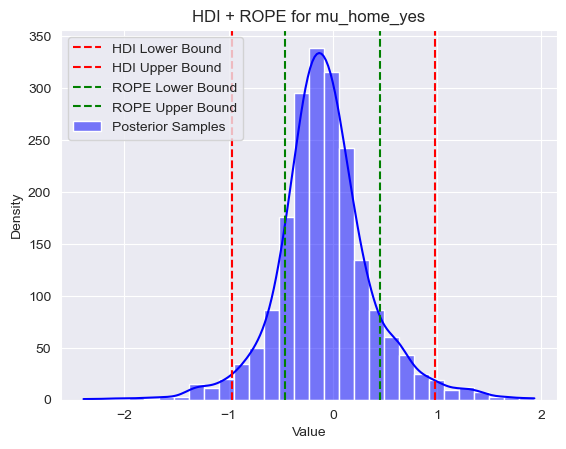

Local tests: ['Undecided', 'Undecided']
Global test for mu: Undecided
Pooling Factor (normal): 0.8351
--------- Predictor 12 ---------
beta_urban_yes_env_0 HDI: [-0.5305, 0.1001]
beta_urban_yes_env_0 ROPE: [-0.0162, 0.0162]


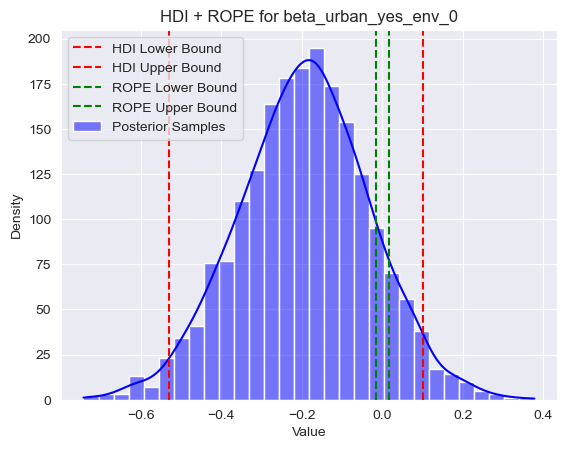

beta_urban_yes_env_1 HDI: [-1.1065, 0.2785]
beta_urban_yes_env_1 ROPE: [-0.0357, 0.0357]


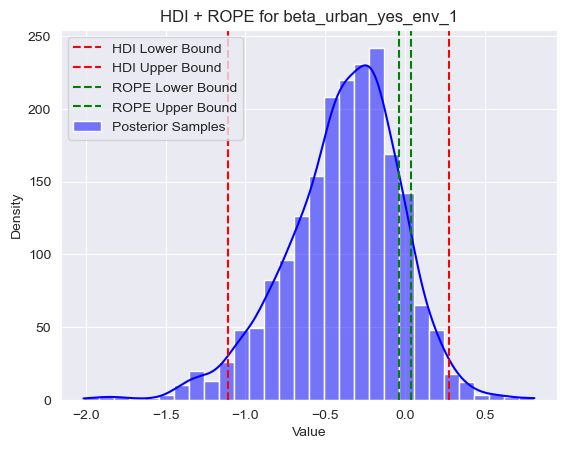

mu_urban_yes HDI: [-1.1287, 0.5388]
mu_urban_yes ROPE: [-0.3983, 0.3983]


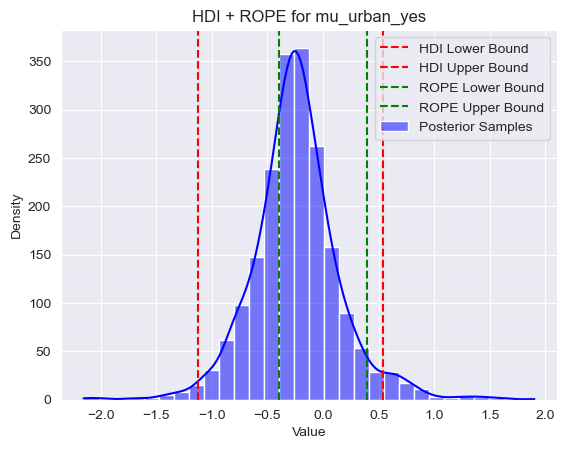

Local tests: ['Undecided', 'Undecided']
Global test for mu: Undecided
Pooling Factor (normal): 0.9475
--------- Predictor 13 ---------
beta_income_low_env_0 HDI: [-0.7731, -0.1993]
beta_income_low_env_0 ROPE: [-0.0150, 0.0150]


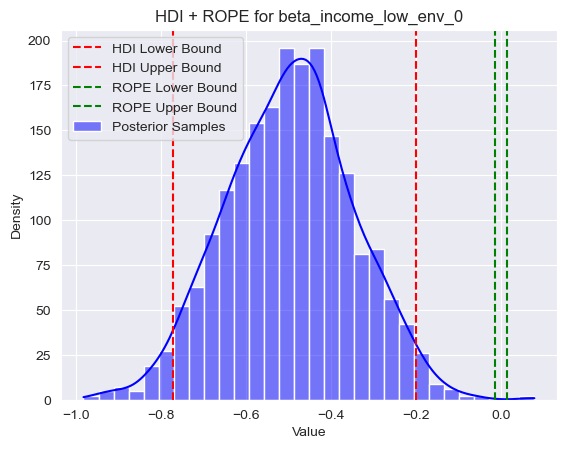

beta_income_low_env_1 HDI: [-0.8834, -0.1526]
beta_income_low_env_1 ROPE: [-0.0189, 0.0189]


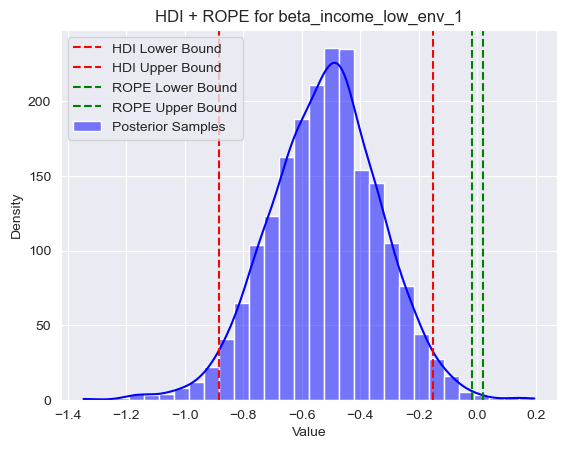

mu_income_low HDI: [-1.3113, 0.2814]
mu_income_low ROPE: [-0.3817, 0.3817]


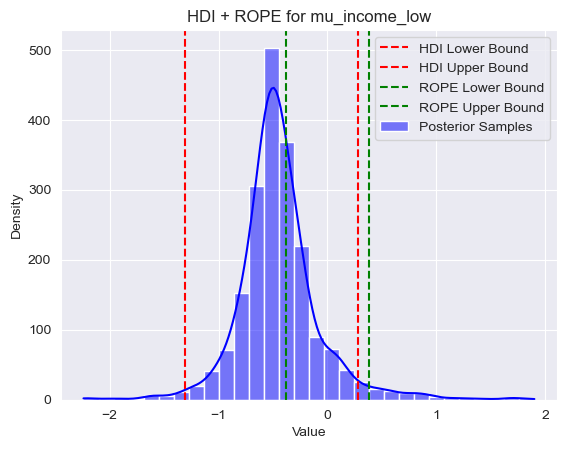

Local tests: ['Rejected', 'Rejected']
Global test for mu: Undecided
Pooling Factor (normal): 0.9991
--------- Predictor 14 ---------
beta_region_west_env_0 HDI: [-1.2694, -0.3003]
beta_region_west_env_0 ROPE: [-0.0248, 0.0248]


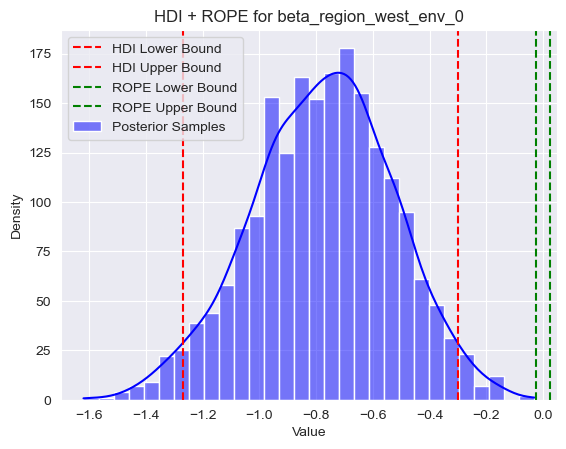

beta_region_west_env_1 HDI: [-1.1205, 0.0246]
beta_region_west_env_1 ROPE: [-0.0293, 0.0293]


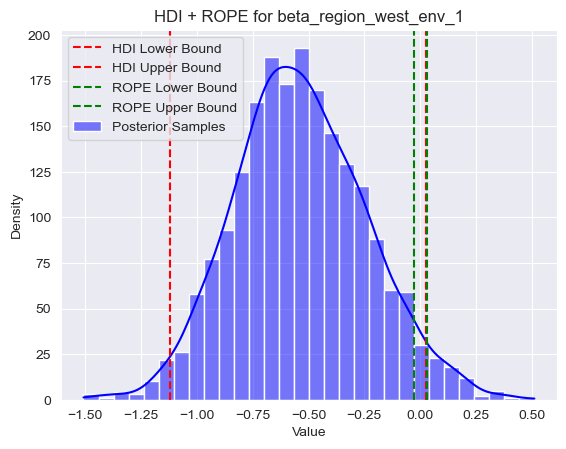

mu_region_west HDI: [-1.3594, 0.4733]
mu_region_west ROPE: [-0.4601, 0.4601]


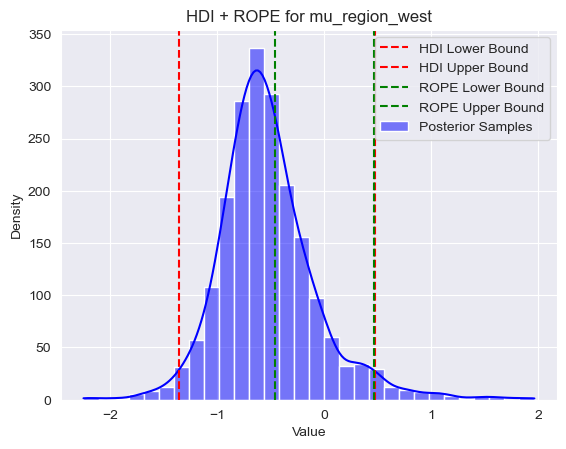

Local tests: ['Rejected', 'Undecided']
Global test for mu: Undecided
Pooling Factor (normal): 0.9325
CONCLUSION
Predictors with significant mu (mu_pass): []
Predictors with significant beta in all environments (beta_pass): [0, 3, 13]
Predictors with high pooling factor (pool_pass): [0, 1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14]


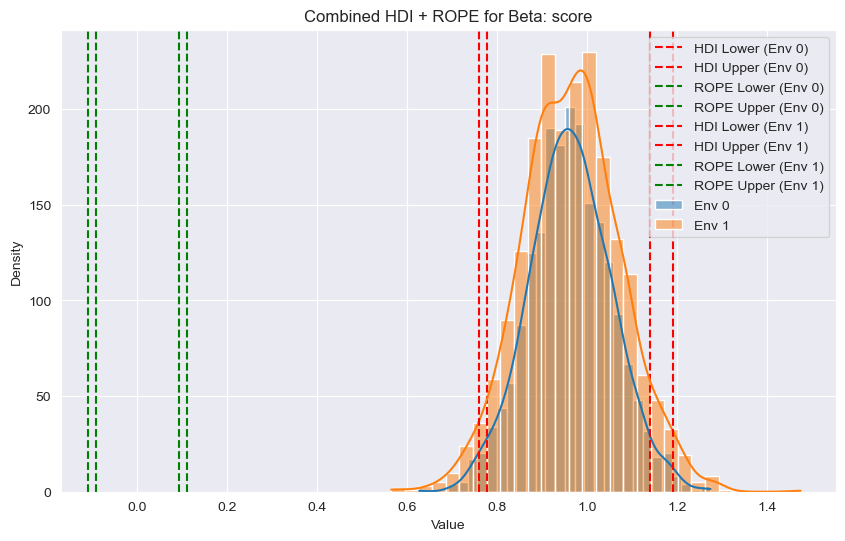

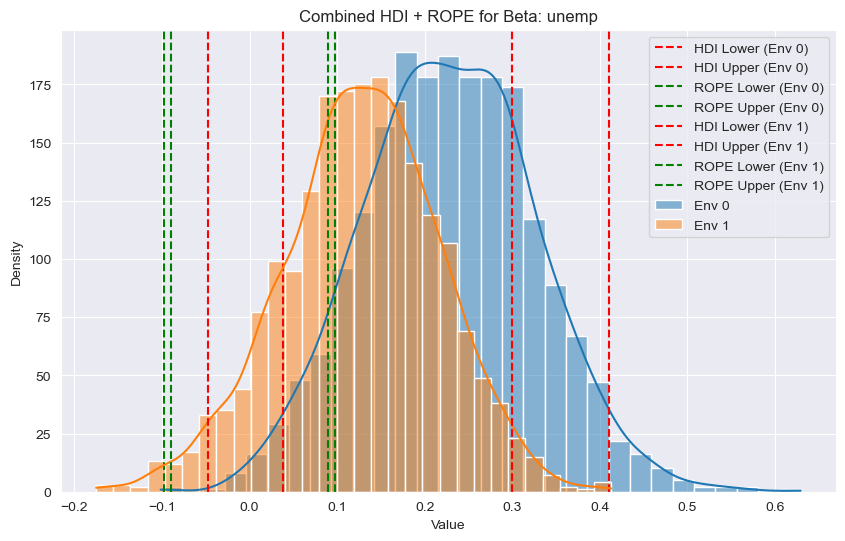

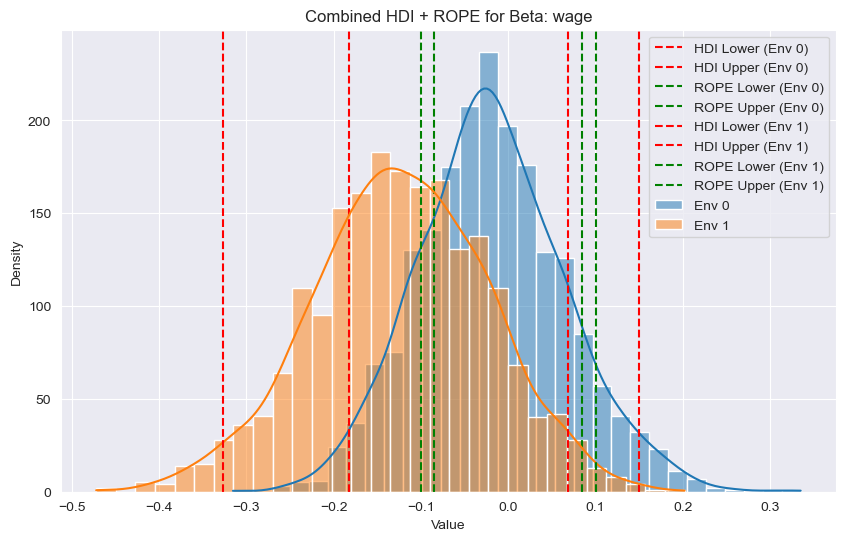

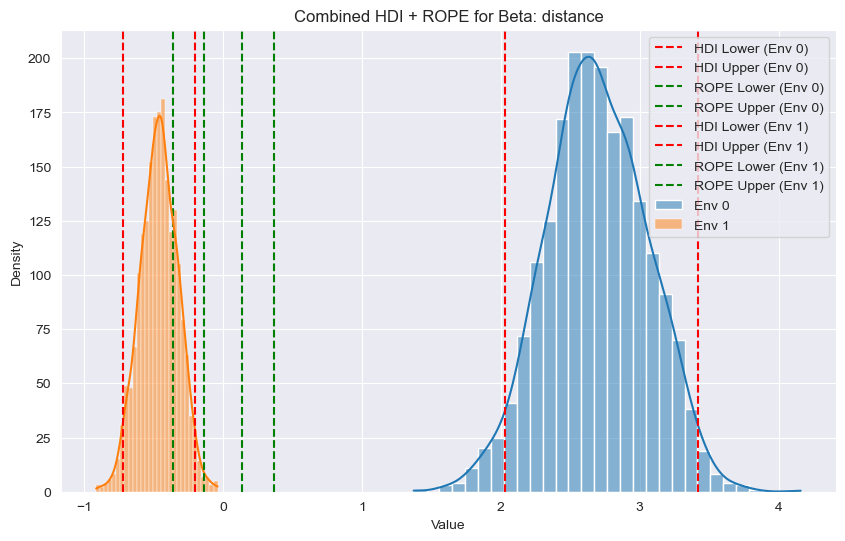

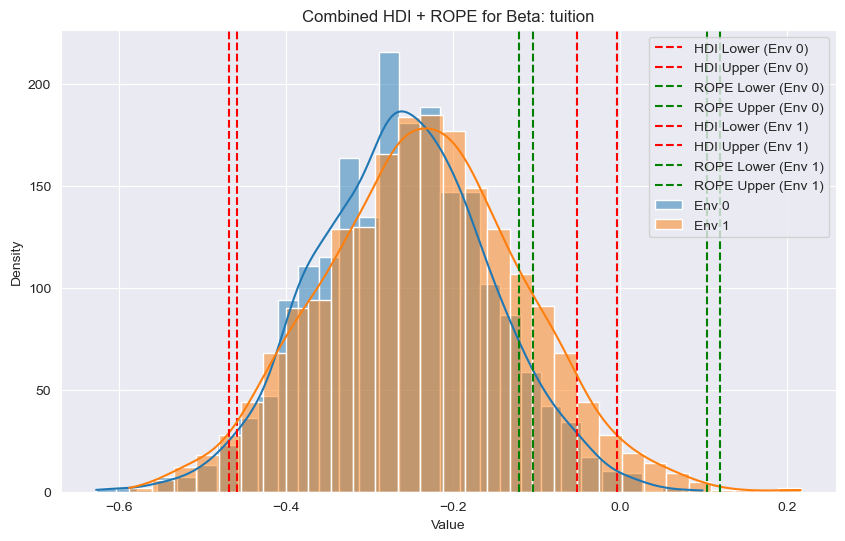

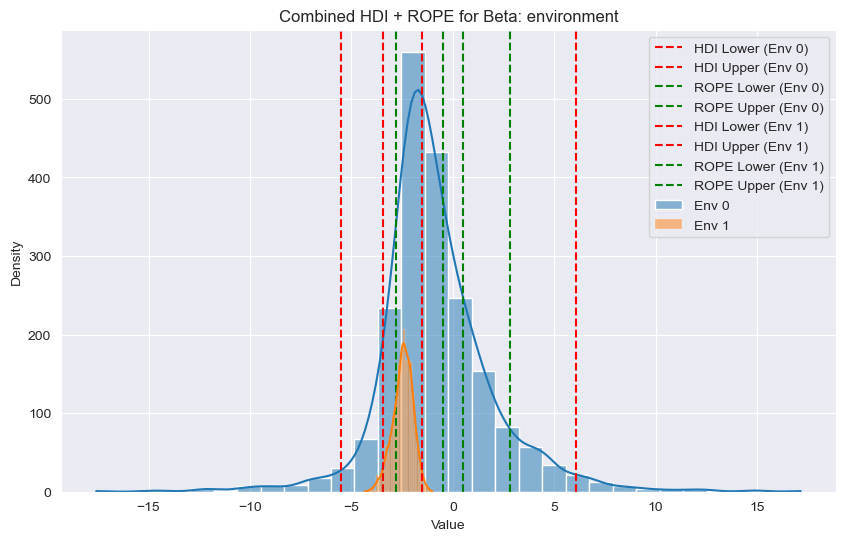

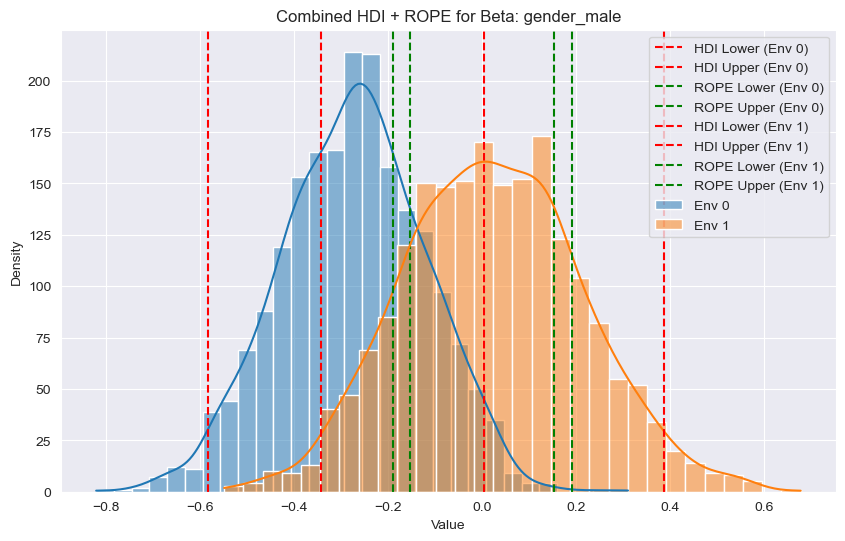

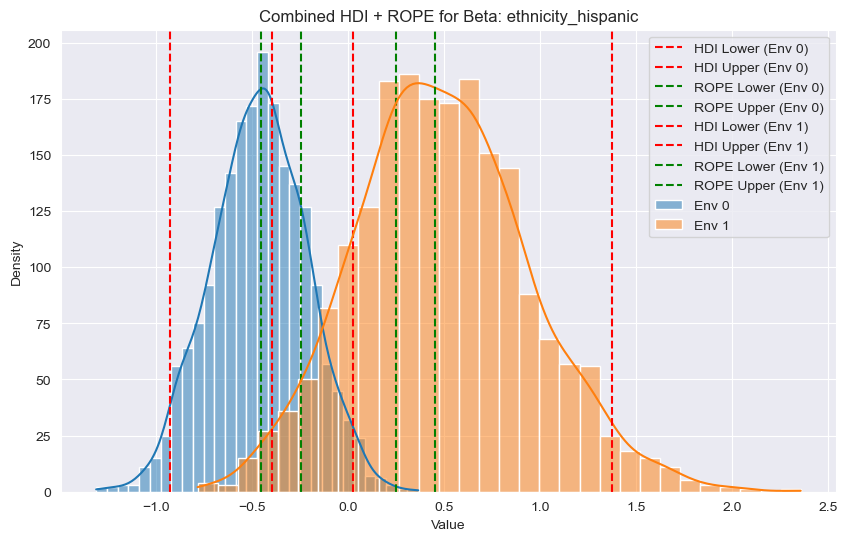

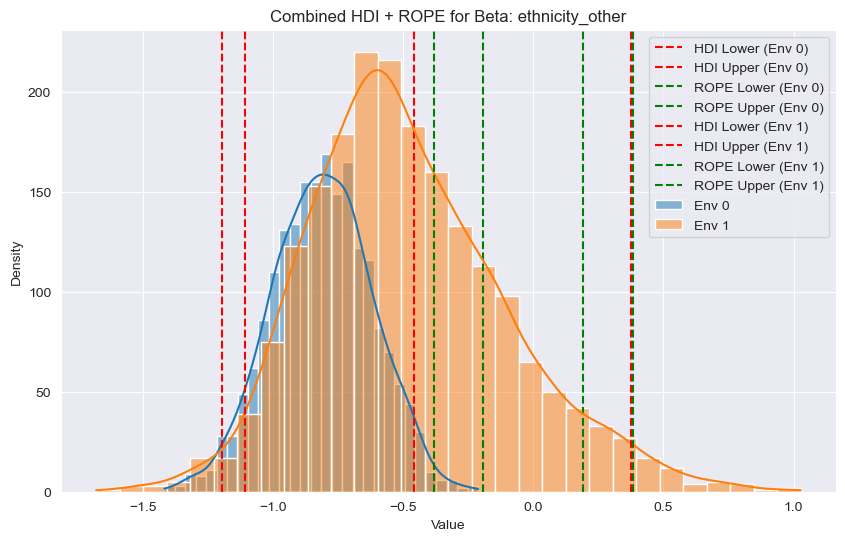

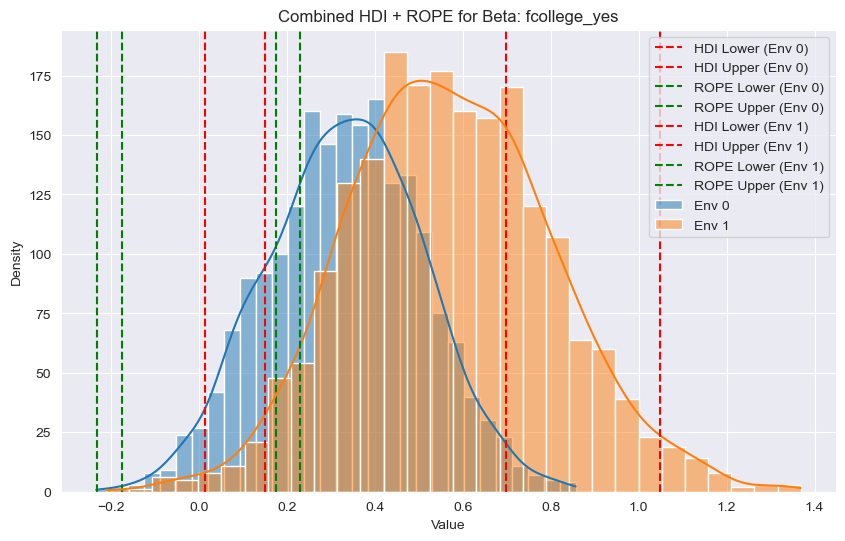

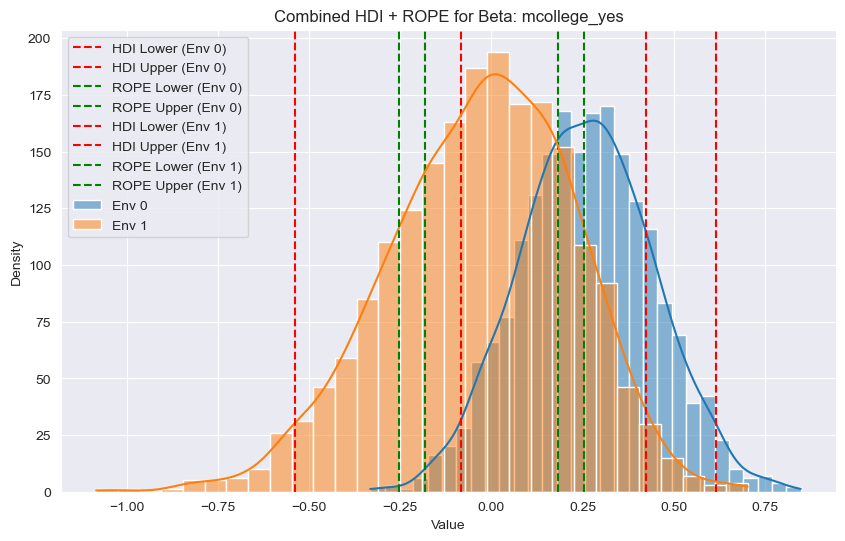

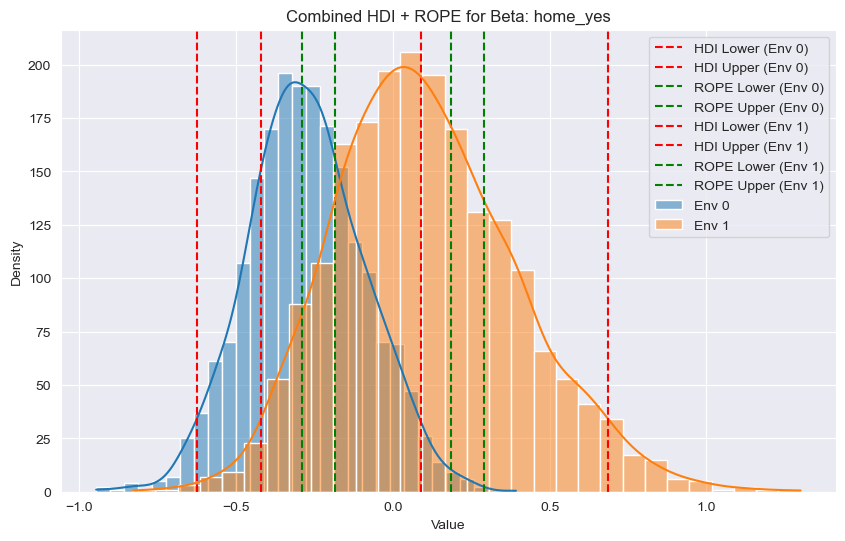

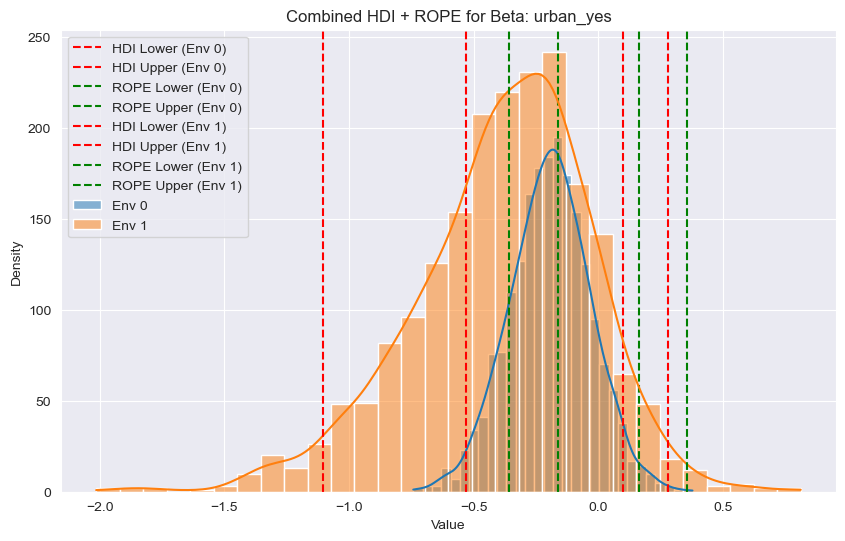

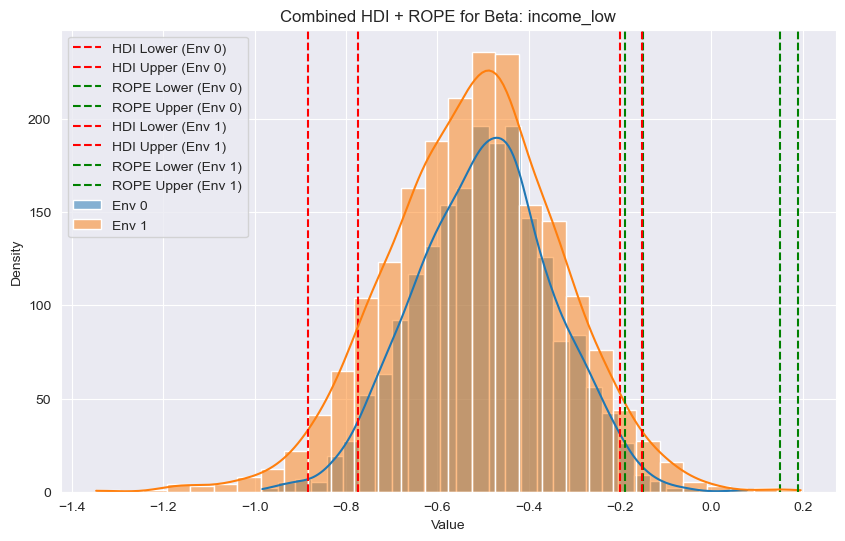

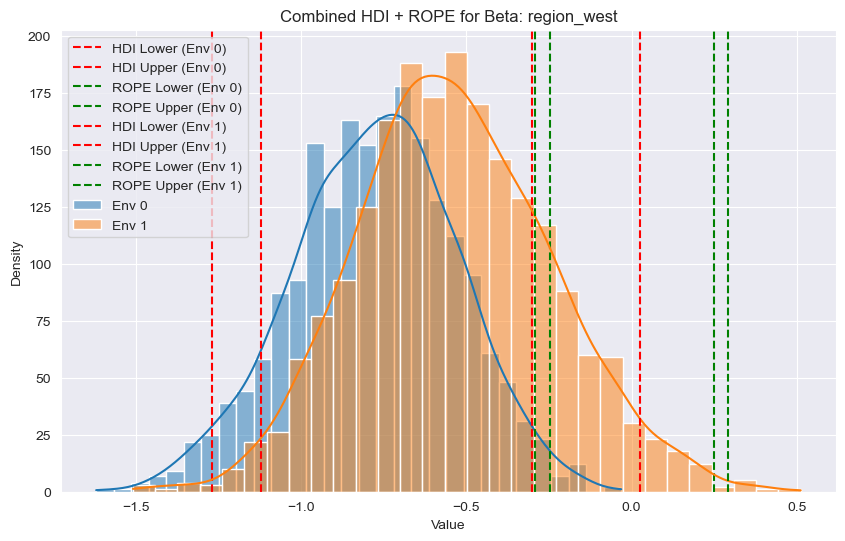

In [75]:
#random_env_assignments = np.random.choice(n_environments, size=len(Y), replace=True)
#e_jax = jnp.array(random_env_assignments, dtype=jnp.int32)

# Define the subset indices (e.g., first 100 samples or a specific filter)
#total_samples = X_jax.shape[0]

# Generate 50 random indices
#random_key = random.PRNGKey(42)  # Random seed
#subset_indices = random.choice(random_key, total_samples, shape=(1000,), replace=False)

# Slice your data
#X_subset = X_jax[subset_indices, :]
#Y_subset = Y_jax[subset_indices]
#e_subset = e_jax[subset_indices]

nuts_kernel = NUTS(nc_hierarchical_model_general)
mcmc = MCMC(nuts_kernel, num_warmup=1000, num_samples=2000, num_chains=1)
mcmc.run(random.PRNGKey(42), N=X_jax.shape[0], D=X_jax.shape[1],
         E=E, e=e_jax, X=X_jax, y=Y_jax, model_func=hierarchical_logistic_model)
posterior_samples = mcmc.get_samples()

invariance_results = invariance_tests(
    posterior_samples,
    D=X_jax.shape[1],
    E=E,
    global_rope="tenth_sd",
    local_rope="tenth_sd",
    printing=True,
    X_cols=X_cols
)

In [76]:
mcmc.print_summary()


                           mean       std    median      5.0%     95.0%     n_eff     r_hat
 beta_decentered[0,0]      0.10      0.76      0.16     -1.17      1.30   1480.24      1.00
 beta_decentered[0,1]      0.25      0.79      0.23     -0.91      1.66   1433.71      1.00
 beta_decentered[0,2]      0.19      0.77      0.17     -0.93      1.56   1269.08      1.00
 beta_decentered[0,3]      1.20      0.60      1.14      0.30      2.17   1618.65      1.00
 beta_decentered[0,4]     -0.09      0.75     -0.08     -1.30      1.17   1546.61      1.00
 beta_decentered[0,5]      0.02      0.99      0.01     -1.63      1.57   2822.63      1.00
 beta_decentered[0,6]     -0.38      0.78     -0.34     -1.61      0.92   1638.78      1.00
 beta_decentered[0,7]     -0.63      0.71     -0.58     -1.80      0.52   1334.08      1.00
 beta_decentered[0,8]     -0.42      0.82     -0.47     -1.68      1.02   1509.72      1.00
 beta_decentered[0,9]     -0.20      0.82     -0.15     -1.64      1.06   1216.

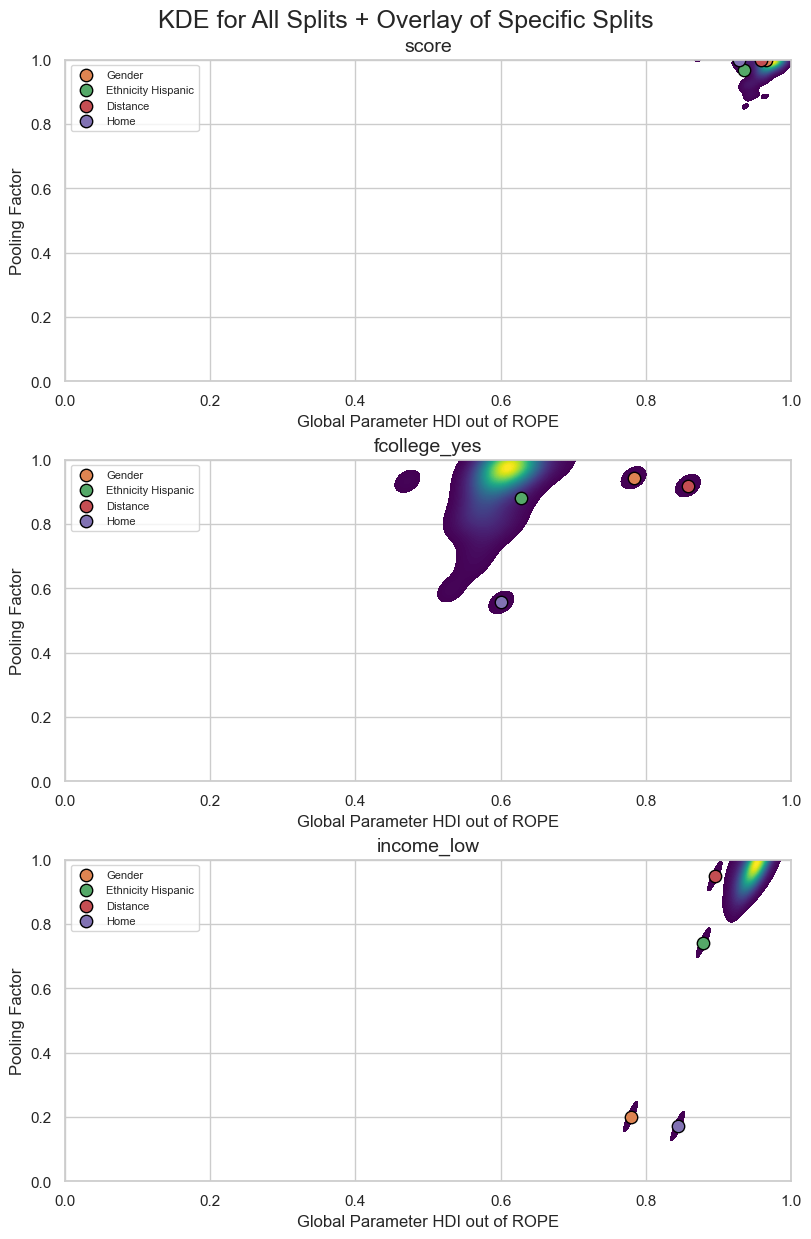

In [146]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set style to whitegrid for better readability
sns.set_theme(style="whitegrid")

# Your plotting code remains unchanged except for style adjustments
X_cols = ["score", "fcollege_yes", "income_low"]
n_predictors = len(X_cols)
n_cols = 1
n_rows = (n_predictors + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(8, n_rows * 4), constrained_layout=True)
axes = axes.flatten()

for idx, predictor in enumerate(X_cols):
    global_values_random = []
    pooling_values_random = []
    for df_split in split_results:
        row = df_split.loc[df_split['Predictor'] == predictor]
        if not row.empty:
            global_values_random.append(row['Global Outcome'].values[0])
            pooling_values_random.append(row['Pooling Factor'].values[0])

    specific_points = {}
    global_values_specific = []
    pooling_values_specific = []
    for env_name, df_specific in specific_split_results.items():
        row_sp = df_specific.loc[df_specific['Predictor'] == predictor]
        if not row_sp.empty:
            gv = row_sp['Global Outcome'].values[0]
            pv = row_sp['Pooling Factor'].values[0]
            specific_points[env_name] = (gv, pv)
            global_values_specific.append(gv)
            pooling_values_specific.append(pv)

    all_global_values = global_values_random + global_values_specific
    all_pooling_values = pooling_values_random + pooling_values_specific

    sns.kdeplot(
        x=all_global_values,
        y=all_pooling_values,
        ax=axes[idx],
        fill=True,
        clip=((0, 1), (0, 1)),
        levels=100,
        cmap="viridis",
    )
    axes[idx].set_title(f"{predictor}", fontsize=14)
    axes[idx].set_xlabel("Global Parameter HDI out of ROPE")
    axes[idx].set_ylabel("Pooling Factor")
    axes[idx].set_xlim(0, 1)
    axes[idx].set_ylim(0, 1)

    for env_name, (gv, pv) in specific_points.items():
        axes[idx].scatter(
            gv,
            pv,
            label=env_name,
            edgecolor='black',
            s=80
        )

    axes[idx].legend(loc='upper left', fontsize=8)

for ax in axes[n_predictors:]:
    ax.axis('off')

plt.suptitle("KDE for All Splits + Overlay of Specific Splits", fontsize=18, y=1.02)
plt.show()


# ICP

In [102]:
df

score  unemp  wage  distance  tuition  education  environment  \
0     39.150002    6.2  8.09       0.2  0.88915          0            0   
1     48.869999    6.2  8.09       0.2  0.88915          0            0   
2     48.740002    6.2  8.09       0.2  0.88915          0            0   
3     40.400002    6.2  8.09       0.2  0.88915          0            0   
4     40.480000    5.6  8.09       0.4  0.88915          0            0   
...         ...    ...   ...       ...      ...        ...          ...   
4734  56.529999    6.6  8.89       0.8  0.25751          0            0   
4735  59.770000    6.6  8.89       0.8  0.25751          0            0   
4736  43.169998    6.6  8.89       0.8  0.25751          0            0   
4737  49.970001    6.6  8.89       0.8  0.25751          0            0   
4738  53.410000    6.6  8.89       0.8  0.25751          0            0   

      gender_male  ethnicity_hispanic  ethnicity_other  fcollege_yes  \
0            True               False             True          True   
1           False               False             True         False   
2            True               False             True         False   
3            True               False            False         False   
4           False               False             True         False   
...           ...                 ...              ...           ...   
4734         True               False            False         False   
4735         True               False            False         False   
4736         True               False             True         False   
4737         True               False            False          True   
4738         True               False            False         False   

      mcollege_yes  home_yes  urban_yes  income_low  region_west  
0            False      True       True       False        False  
1            False      True       True        True        False  
2            False      True       True        True        False  
3            False      True       True        True        False  
4            False     False       True        True        False  
...            ...       ...        ...         ...          ...  
4734         False      True      False       False         True  
4735         False      True      False       False         True  
4736         False      True      False       False         True  
4737          True      True      False       False         True  
4738          True      True      False       False         True  

[4739 rows x 16 columns]

In [143]:
import causalicp as icp

# Load the dataset
url = "https://vincentarelbundock.github.io/Rdatasets/csv/AER/CollegeDistance.csv"
df = pd.read_csv(url)

# Drop unnecessary columns and binarize the target
df = df.drop(columns=["rownames"])
df['education'] = (df['education'] > 16).astype(int)

# Define environments based on distance
df["environment"] = np.where(df["distance"] <= df["distance"].median(), 0, 1)

# Scale continuous predictors
scaler = StandardScaler()
continuous_cols = ['score', 'tuition', 'unemp', 'wage']
df[continuous_cols] = scaler.fit_transform(df[continuous_cols])

# Convert categorical variables to dummies
df = pd.get_dummies(
    df,
    columns=['gender', 'ethnicity', 'fcollege', 'mcollege', 'home', 'urban', 'income', 'region'],
    drop_first=True
)

# Prepare data for ICP based on the environment split
X_cols = [col for col in df.columns if col not in ['education', 'environment']]
outcome = "education"
data_e = []

unique_envs = np.unique(df["environment"])
for env in unique_envs:
    df_env = df[df["environment"] == env]
    X_env = df_env[X_cols].values  # Predictors
    Y_env = df_env[outcome].values  # Target variable
    data_env = np.hstack([X_env, Y_env.reshape(-1, 1)])  # Combine predictors and target
    data_e.append(data_env)

# Define variable names and target index
variable_names = X_cols + [outcome]
target_index = variable_names.index(outcome)

# Run ICP
result = icp.fit(data_e, target=target_index, alpha=0.05, precompute=True, verbose=True, color=False)

# Output results
if result.estimate is not None:
    invariant_predictors = [variable_names[i] for i in result.estimate]
    print("Invariant predictors identified:", invariant_predictors)
    print("P-values for tested sets:", result.p_values)
else:
    print("No invariant predictors found.")




Tested sets and their p-values:
  set() rejected : 2.257222941892678e-08
  {0} rejected : 1.671592371188524e-07
  {1} rejected : 2.1102116329943037e-08
  {2} rejected : 2.2608917836301544e-08
  {3} rejected : 1.0934804173245993e-08
  {4} rejected : 2.2765643561079106e-08
  {5} rejected : 1.9896443894035507e-08
  {6} rejected : 2.2412921728375657e-08
  {7} rejected : 3.114580631772487e-08
  {8} rejected : 2.2240694116442293e-08
  {9} rejected : 1.1485134558488018e-07
  {10} rejected : 3.1767403616468794e-08
  {11} rejected : 2.5158207814496293e-08
  {12} rejected : 1.7613935199278785e-08
  {13} rejected : 2.5212742116309528e-08
  {0, 1} rejected : 1.6119104048367523e-07
  {0, 2} rejected : 1.2877945509052315e-07
  {0, 3} rejected : 1.0411419726352733e-07
  {0, 4} rejected : 1.470408839132631e-07
  {0, 5} rejected : 1.5848904011406262e-07
  {0, 6} rejected : 1.0510166914556862e-07
  {0, 7} rejected : 1.2548344168963358e-07
  {0, 8} rejected : 1.2661446376543316e-07
  {0, 9} rejected : 4.

In [141]:
result.accepted_sets
